In [16]:
import jax

import matplotlib.pyplot as plt

In [18]:
RNG = jax.random.PRNGKey(42)

n_trees = 100

In [19]:
rng0, rng1 = jax.random.split(RNG)
params = 2. * jax.random.normal(rng0, (n_trees, 2), dtype=jax.numpy.float16), jax.random.uniform(rng1, (n_trees,),
                                                                                                 dtype=jax.numpy.float16) * 2 * 3.14159

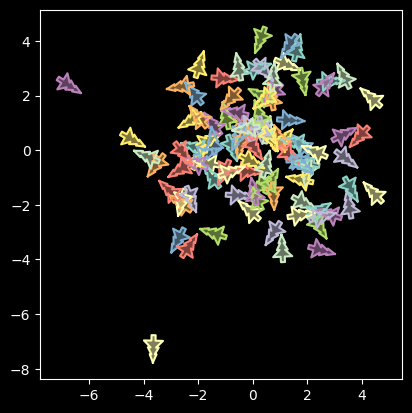

In [20]:
from santa import base, core
from santa.constraints import intersection

trees_ = base.params_to_trees(params)
base.plot(trees_)

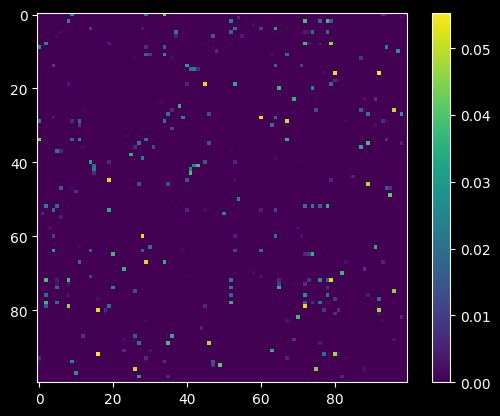

In [21]:


trees = jax.vmap(core.instantiate_tree)(params)

intersection_scores = jax.vmap(jax.vmap(intersection.tree_intersection_score, (0, None)), (None, 0))(
    trees,
    trees
).max((2, 3)).clip(0, 1e12)
intersection_scores = jax.numpy.fill_diagonal(intersection_scores, 0, inplace=False)

plt.imshow(intersection_scores)
plt.colorbar()

(Array(1464, dtype=int32), Array(600, dtype=int32))

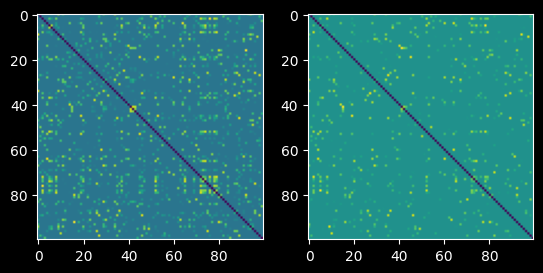

In [77]:
def get_masked_dist_(params):
    thr, delta = 2 * 0.52, 0.28

    pos = params[0]
    ang = params[1]
    delta_pos = jax.numpy.stack([-jax.numpy.sin(ang) * delta, jax.numpy.cos(ang) * delta], -1)
    pos = pos + delta_pos
    pos = jax.numpy.expand_dims(pos, -1)

    dist = ((pos - jax.numpy.swapaxes(pos, 0, 2)) ** 2).sum(1) ** 0.5
    dist = jax.numpy.fill_diagonal(dist, 1 + thr, inplace=False)
    close_mask = (dist < thr).astype(int)
    close_mask = jax.numpy.fill_diagonal(close_mask, -1, inplace=False)

    masked_dist = jax.numpy.where(close_mask > 0, thr - dist, close_mask)
    return masked_dist

def get_masked_dist(params, thr, dist_type="l2"):
    pos = params[0]
    pos = jax.numpy.expand_dims(pos, -1)

    if dist_type == "l1":
        dist = jax.numpy.abs(pos - jax.numpy.swapaxes(pos, 0, 2)).sum(1)
    elif dist_type == "l2":
        dist = ((pos - jax.numpy.swapaxes(pos, 0, 2)) ** 2).sum(1) ** 0.5
    elif dist_type == "linf":
        dist = jax.numpy.abs(pos - jax.numpy.swapaxes(pos, 0, 2)).max(1)
    else:
        raise ValueError

    dist = jax.numpy.fill_diagonal(dist, 1 + thr, inplace=False)

    close_mask = (dist < thr).astype(int)
    close_mask = jax.numpy.fill_diagonal(close_mask, -1, inplace=False)

    masked_dist = jax.numpy.where(close_mask > 0, thr - dist, close_mask)
    return masked_dist


def get_close_trees(trees, masked_dist, num):
    indexes = jax.numpy.argsort(masked_dist, descending=True)[:, :num]
    return jax.vmap(lambda i: trees[indexes[i]])(jax.numpy.arange(trees.shape[0]))


def get_intersection_from_close_trees(trees, close_trees):
    intersection_scores = jax.vmap(jax.vmap(intersection.tree_intersection_score, (None, 0)), (0, 0))(
        trees,
        close_trees
    ).max((2, 3)).clip(0, 1e12)
    intersection_scores = jax.numpy.clip(intersection_scores, 0)
    return intersection_scores


masked_dist = get_masked_dist(params, thr=1.6, dist_type="l2")


masked_dist_ = get_masked_dist_(params)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(masked_dist)
ax[1].imshow(masked_dist_)

(masked_dist > 0).sum(), (masked_dist_ > 0).sum()

In [85]:
masked_dist = get_masked_dist_(params)

trees = jax.vmap(core.instantiate_tree)(params)
close_trees = get_close_trees(trees, masked_dist, 12)

intersection_scores1 = get_intersection_from_close_trees(trees, close_trees)


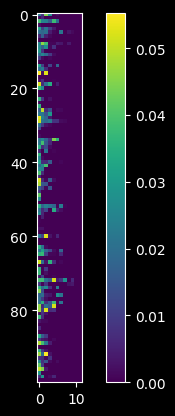

In [86]:
plt.imshow(intersection_scores1)
plt.colorbar()

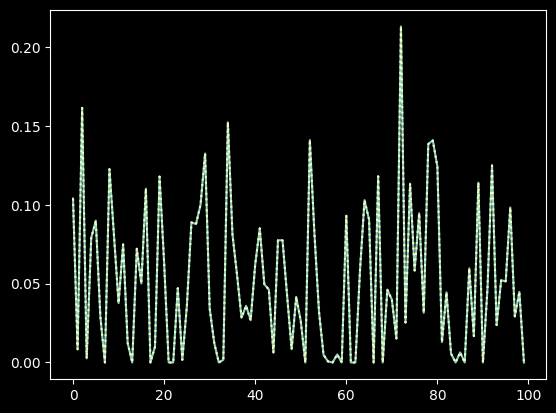

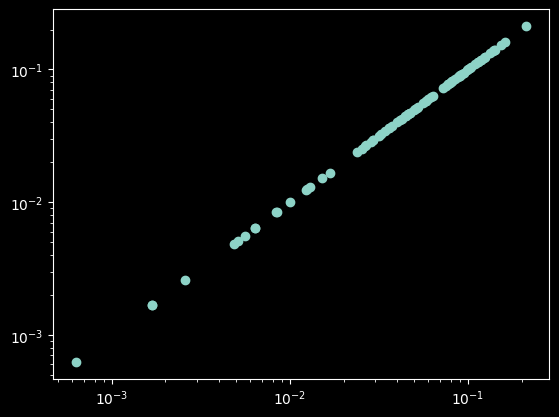

In [87]:
plt.plot(intersection_scores.sum(-1))
plt.plot(intersection_scores1.sum(-1), linestyle=":")

plt.figure()
plt.scatter(intersection_scores.sum(-1), intersection_scores1.sum(-1))
plt.xscale("log")
plt.yscale("log");